## Metalearning Test V1

Processing VIX data...
VIX data loaded successfully!
Data range: 1990-04-02 00:00:00 to 2025-05-09 00:00:00
Number of days: 8861

Preparing VIX data for forecasting...

Forecasting dataset created:
Training samples: 7024
Testing samples: 1757
Input shape: (7024, 60, 14)
Target shape: (7024, 21, 1)

Data saved to 'vix_data.pt' and 'vix_model_data.pt'


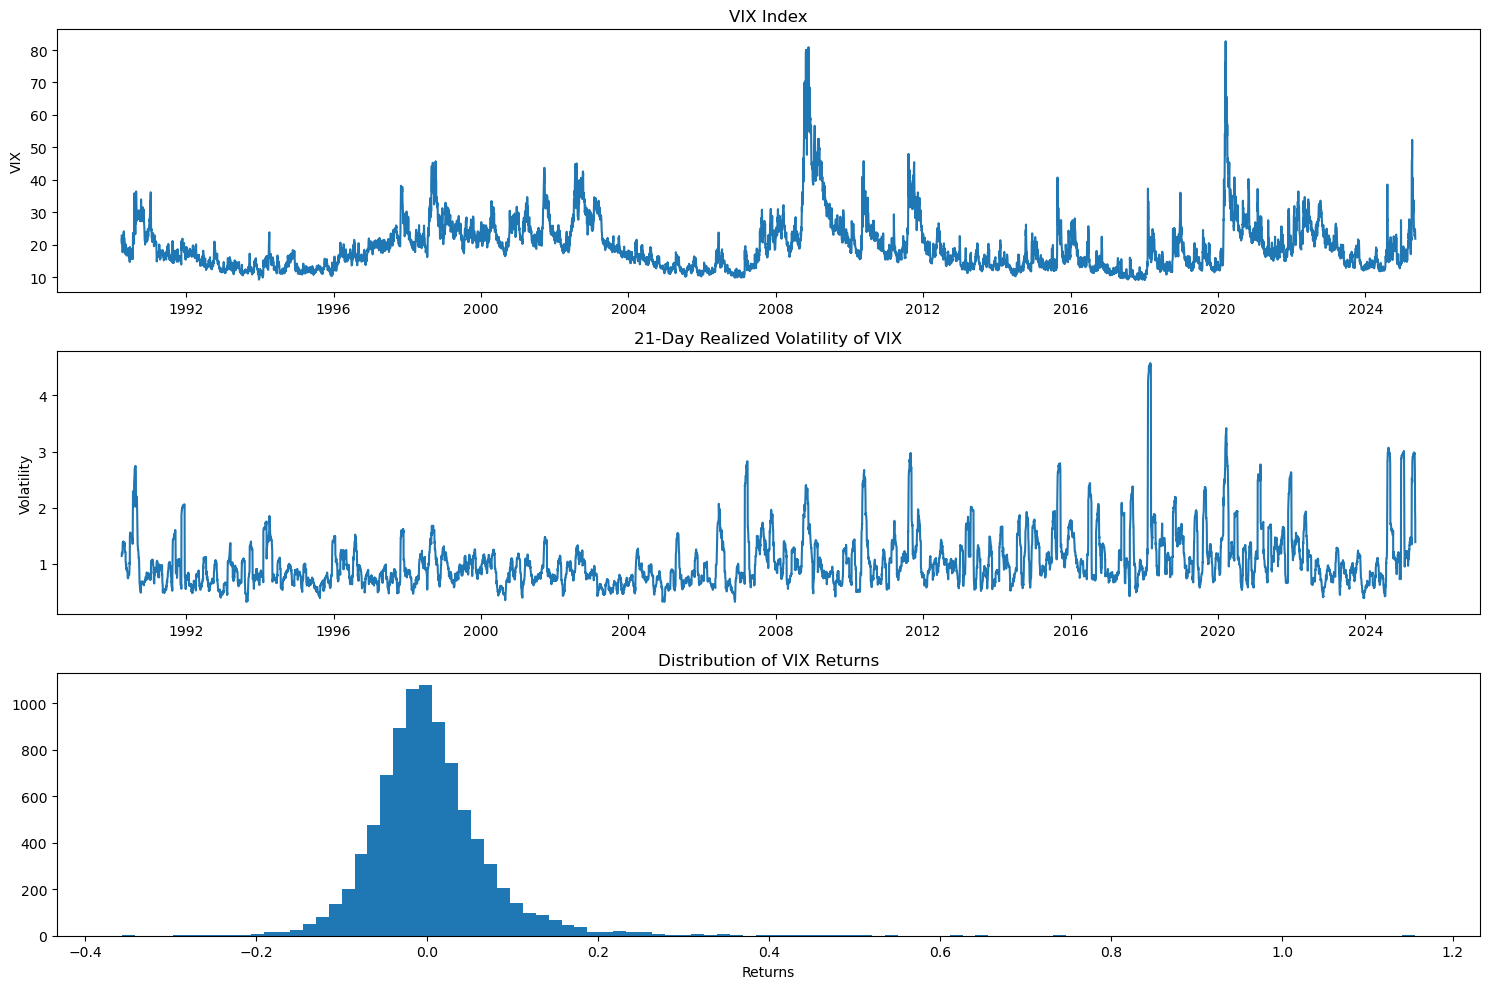

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.preprocessing import StandardScaler
import datetime as dt

def process_vix_data(file_path):
    """Process VIX data from CSV file"""
    
    # Read the data
    # Assuming the data is in a CSV format with the columns as shown
    df = pd.read_csv(file_path, parse_dates=['DATE'])
    
    # Rename columns to standard format
    df.columns = [col.lower() for col in df.columns]
    
    # Set the date as the index
    df.set_index('date', inplace=True)
    
    # Calculate returns
    df['returns'] = df['close'].pct_change()
    
    # Calculate volatility features
    # Historical volatility (standard deviation of returns)
    df['vol_5d'] = df['returns'].rolling(5).std() * np.sqrt(252)  # 1-week
    df['vol_10d'] = df['returns'].rolling(10).std() * np.sqrt(252)  # 2-weeks
    df['vol_21d'] = df['returns'].rolling(21).std() * np.sqrt(252)  # 1-month (target)
    df['vol_63d'] = df['returns'].rolling(63).std() * np.sqrt(252)  # 3-months
    
    # Moving averages
    df['ma5'] = df['close'].rolling(5).mean()
    df['ma20'] = df['close'].rolling(20).mean()
    df['ma50'] = df['close'].rolling(50).mean()
    
    # Price to moving average ratios
    df['price_to_ma20'] = df['close'] / df['ma20']
    df['price_to_ma50'] = df['close'] / df['ma50']
    
    # Range-based volatility
    df['daily_range'] = (df['high'] - df['low']) / df['close']
    df['range_ma5'] = df['daily_range'].rolling(5).mean()
    
    # Momentum features
    df['momentum_5d'] = df['close'].pct_change(5)
    df['momentum_10d'] = df['close'].pct_change(10)
    df['momentum_21d'] = df['close'].pct_change(21)
    
    # Calendar features
    df['day_of_week'] = df.index.dayofweek / 6.0
    df['month'] = (df.index.month - 1) / 11.0
    df['quarter'] = (df.index.quarter - 1) / 3.0
    df['year'] = (df.index.year - df.index.year.min()) / (df.index.year.max() - df.index.year.min())
    
    # Drop NaN values
    df.dropna(inplace=True)
    
    return df

def prepare_vix_data_for_forecasting(df, window_size=60, forecast_horizon=21, test_ratio=0.2):
    """Prepare VIX data for forecasting"""
    
    # Define feature columns
    feature_cols = [
        'vol_5d', 'vol_10d', 'vol_63d', 
        'price_to_ma20', 'price_to_ma50',
        'daily_range', 'range_ma5',
        'momentum_5d', 'momentum_10d', 'momentum_21d',
        'day_of_week', 'month', 'quarter', 'year'
    ]
    
    # Target column
    target_col = 'vol_21d'
    
    # Scale features and target
    scaler_features = StandardScaler()
    scaler_target = StandardScaler()
    
    # Create a copy
    df_scaled = df.copy()
    
    # Fit and transform
    df_scaled[feature_cols] = scaler_features.fit_transform(df[feature_cols])
    df_scaled[[target_col]] = scaler_target.fit_transform(df[[target_col]])
    
    # Extract scaled data
    X = df_scaled[feature_cols].values
    y = df_scaled[target_col].values
    
    # Create sliding windows
    X_windows, y_windows = [], []
    
    for i in range(len(df) - window_size - forecast_horizon + 1):
        X_windows.append(X[i:i+window_size])
        y_windows.append(y[i+window_size:i+window_size+forecast_horizon])
    
    X_windows = np.array(X_windows)
    y_windows = np.array(y_windows).reshape(-1, forecast_horizon, 1)  # Add feature dimension
    
    # Split into train/test
    split_idx = int(len(X_windows) * (1 - test_ratio))
    
    # Create a task ID for this series (just 0 since it's a single series)
    task_id = np.zeros(len(X_windows), dtype=int)
    
    data = {
        'X_train': X_windows[:split_idx],
        'y_train': y_windows[:split_idx],
        'task_id_train': task_id[:split_idx],
        'X_test': X_windows[split_idx:],
        'y_test': y_windows[split_idx:],
        'task_id_test': task_id[split_idx:],
        'feature_scaler': scaler_features,
        'target_scaler': scaler_target,
        'feature_cols': feature_cols,
        'target_col': target_col,
        'dates': df.index,
        'raw_data': df
    }
    
    return data

def format_vix_for_models(data, val_ratio=0.1):
    """Format VIX data for TFT, NBEATSx, and DeepAR models"""
    
    # Split training data into train/val
    n_train = len(data['X_train'])
    val_idx = int(n_train * (1 - val_ratio))
    
    X_train = data['X_train'][:val_idx]
    y_train = data['y_train'][:val_idx]
    task_train = data['task_id_train'][:val_idx]
    
    X_val = data['X_train'][val_idx:]
    y_val = data['y_train'][val_idx:]
    task_val = data['task_id_train'][val_idx:]
    
    X_test = data['X_test']
    y_test = data['y_test']
    task_test = data['task_id_test']
    
    # Format for different models
    model_data = {}
    
    # 1. TFT Format
    # Identify calendar features (known in the future)
    calendar_indices = [-4, -3, -2, -1]  # day_of_week, month, quarter, year indices
    
    tft_data = {
        'train': {
            'static_inputs': [torch.tensor(task_train, dtype=torch.long)],
            'encoder_inputs': [
                torch.tensor(X_train, dtype=torch.float32)
            ],
            'decoder_future_inputs': [
                # Calendar features for the forecast horizon
                # In a real application, we would use actual future calendar features
                # Here we'll just use zeros as placeholders
                torch.zeros((X_train.shape[0], y_train.shape[1], len(calendar_indices)), dtype=torch.float32)
            ],
            'targets': torch.tensor(y_train, dtype=torch.float32)
        },
        'val': {
            'static_inputs': [torch.tensor(task_val, dtype=torch.long)],
            'encoder_inputs': [
                torch.tensor(X_val, dtype=torch.float32)
            ],
            'decoder_future_inputs': [
                torch.zeros((X_val.shape[0], y_val.shape[1], len(calendar_indices)), dtype=torch.float32)
            ],
            'targets': torch.tensor(y_val, dtype=torch.float32)
        },
        'test': {
            'static_inputs': [torch.tensor(task_test, dtype=torch.long)],
            'encoder_inputs': [
                torch.tensor(X_test, dtype=torch.float32)
            ],
            'decoder_future_inputs': [
                torch.zeros((X_test.shape[0], y_test.shape[1], len(calendar_indices)), dtype=torch.float32)
            ],
            'targets': torch.tensor(y_test, dtype=torch.float32)
        }
    }
    model_data['tft'] = tft_data
    
    # 2. NBEATSx Format
    nbeatsx_data = {
        'train': {
            'x': torch.tensor(X_train, dtype=torch.float32),
            'y': torch.tensor(y_train.squeeze(-1), dtype=torch.float32),
            'task_ids': torch.tensor(task_train, dtype=torch.long)
        },
        'val': {
            'x': torch.tensor(X_val, dtype=torch.float32),
            'y': torch.tensor(y_val.squeeze(-1), dtype=torch.float32),
            'task_ids': torch.tensor(task_val, dtype=torch.long)
        },
        'test': {
            'x': torch.tensor(X_test, dtype=torch.float32),
            'y': torch.tensor(y_test.squeeze(-1), dtype=torch.float32),
            'task_ids': torch.tensor(task_test, dtype=torch.long)
        }
    }
    model_data['nbeatsx'] = nbeatsx_data
    
    # 3. DeepAR Format
    # Use VIX itself as the main series and the rest as features
    deepar_data = {
        'train': {
            'time_series': torch.tensor(X_train[:, :, 0:1], dtype=torch.float32),  # Just using vol_5d as the main series
            'time_features': torch.tensor(X_train[:, :, 1:], dtype=torch.float32),  # Rest as time features
            'static_features': torch.tensor(task_train.reshape(-1, 1), dtype=torch.float32),  # Task IDs as static features
            'targets': torch.tensor(y_train, dtype=torch.float32)
        },
        'val': {
            'time_series': torch.tensor(X_val[:, :, 0:1], dtype=torch.float32),
            'time_features': torch.tensor(X_val[:, :, 1:], dtype=torch.float32),
            'static_features': torch.tensor(task_val.reshape(-1, 1), dtype=torch.float32),
            'targets': torch.tensor(y_val, dtype=torch.float32)
        },
        'test': {
            'time_series': torch.tensor(X_test[:, :, 0:1], dtype=torch.float32),
            'time_features': torch.tensor(X_test[:, :, 1:], dtype=torch.float32),
            'static_features': torch.tensor(task_test.reshape(-1, 1), dtype=torch.float32),
            'targets': torch.tensor(y_test, dtype=torch.float32)
        }
    }
    model_data['deepar'] = deepar_data
    
    return model_data

def main_vix(file_path):
    """Main function for processing VIX data"""
    
    print("Processing VIX data...")
    vix_df = process_vix_data(file_path)
    
    print("VIX data loaded successfully!")
    print(f"Data range: {vix_df.index.min()} to {vix_df.index.max()}")
    print(f"Number of days: {len(vix_df)}")
    
    # Plot the VIX data
    plt.figure(figsize=(15, 10))
    
    plt.subplot(3, 1, 1)
    plt.plot(vix_df.index, vix_df['close'])
    plt.title('VIX Index')
    plt.ylabel('VIX')
    
    plt.subplot(3, 1, 2)
    plt.plot(vix_df.index, vix_df['vol_21d'])
    plt.title('21-Day Realized Volatility of VIX')
    plt.ylabel('Volatility')
    
    plt.subplot(3, 1, 3)
    plt.hist(vix_df['returns'], bins=100)
    plt.title('Distribution of VIX Returns')
    plt.xlabel('Returns')
    
    plt.tight_layout()
    plt.savefig('vix_analysis.png')
    
    # Prepare for forecasting
    print("\nPreparing VIX data for forecasting...")
    vix_data = prepare_vix_data_for_forecasting(
        vix_df,
        window_size=60,     # 60 days of history
        forecast_horizon=21,  # 21 days ahead
        test_ratio=0.2
    )
    
    print(f"\nForecasting dataset created:")
    print(f"Training samples: {len(vix_data['X_train'])}")
    print(f"Testing samples: {len(vix_data['X_test'])}")
    print(f"Input shape: {vix_data['X_train'].shape}")
    print(f"Target shape: {vix_data['y_train'].shape}")
    
    # Format for models
    model_data = format_vix_for_models(vix_data)
    
    # Save the prepared data
    torch.save(vix_data, 'vix_data.pt')
    torch.save(model_data, 'vix_model_data.pt')
    print("\nData saved to 'vix_data.pt' and 'vix_model_data.pt'")
    
    return vix_data, model_data

if __name__ == "__main__":
    # Replace with the path to your VIX data file
    file_path = "data/real/cboe_data/VIX_History.csv"
    vix_data, model_data = main_vix(file_path)

In [3]:
import pandas_datareader as pdr
import pandas as pd

def get_fred_exog_data(start_date='1990-01-01', end_date='2023-01-01'):
    """Get exogenous variables from FRED for volatility forecasting"""
    
    # Dictionary of indicators to fetch
    indicators = {
        'VIX': 'VIXCLS',                # VIX (our target)
        'SP500': 'SP500',               # S&P 500 Index
        'T10Y2Y': 'T10Y2Y',             # 10Y-2Y Treasury Spread (recession indicator)
        'UNRATE': 'UNRATE',             # Unemployment Rate
        'STLFSI': 'STLFSI2',            # St. Louis Fed Financial Stress Index
        'BAA10Y': 'BAA10Y',             # BAA Corporate Bond - 10Y Treasury Spread
        'TEDRATE': 'TEDRATE',           # TED Spread (3M LIBOR - 3M T-Bill)
        'USREC': 'USREC',               # US Recession Indicator
        'T10YIE': 'T10YIE',             # 10-Year Breakeven Inflation Rate
        'CFNAI': 'CFNAI'                # Chicago Fed National Activity Index
    }
    
    # Fetch data
    data = {}
    for name, fred_code in indicators.items():
        try:
            series = pdr.get_data_fred(fred_code, start_date, end_date)
            if isinstance(series, pd.DataFrame):
                series.columns = [name]
            else:
                series = pd.DataFrame({name: series})
            data[name] = series
        except Exception as e:
            print(f"Error fetching {name}: {e}")
    
    # Combine all series
    combined = pd.concat([data[name] for name in data if name in data], axis=1)
    
    # Fill missing values with forward fill then backward fill
    combined = combined.fillna(method='ffill').fillna(method='bfill')
    
    return combined

## This cell ##
1. Fetches economic indicators from FRED that correlate with market volatility
2. Processes your VIX data from the CSV file
3. Combines and enhances the dataset with additional features
4. Creates data visualizations to help you understand the data
5. Prepares time series windows for forecasting models
6. Formats the data specifically for TFT, NBEATSx, and DeepAR
7. Saves everything in appropriate formats (CSV for raw data, PyTorch tensors for model inputs, JSON for feature information)

In [ ]:
import pandas_datareader as pdr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import os
import torch
from sklearn.preprocessing import StandardScaler

# Create a data directory if it doesn't exist
os.makedirs('data', exist_ok=True)

# 1. Define function to get FRED data
def get_fred_exog_data(start_date='1990-01-01', end_date='2023-01-01'):
    """Get exogenous variables from FRED for volatility forecasting"""
    
    print(f"Fetching data from FRED ({start_date} to {end_date})...")
    
    # Dictionary of indicators to fetch
    indicators = {
        'VIX': 'VIXCLS',                # VIX (our target)
        'SP500': 'SP500',               # S&P 500 Index
        'T10Y2Y': 'T10Y2Y',             # 10Y-2Y Treasury Spread (recession indicator)
        'UNRATE': 'UNRATE',             # Unemployment Rate
        'STLFSI': 'STLFSI2',            # St. Louis Fed Financial Stress Index
        'BAA10Y': 'BAA10Y',             # BAA Corporate Bond - 10Y Treasury Spread
        'TEDRATE': 'TEDRATE',           # TED Spread (3M LIBOR - 3M T-Bill)
        'USREC': 'USREC',               # US Recession Indicator
        'T10YIE': 'T10YIE',             # 10-Year Breakeven Inflation Rate
        'CFNAI': 'CFNAI'                # Chicago Fed National Activity Index
    }
    
    # Fetch data
    data = {}
    for name, fred_code in indicators.items():
        try:
            print(f"  Fetching {name} ({fred_code})...")
            series = pdr.get_data_fred(fred_code, start_date, end_date)
            if isinstance(series, pd.DataFrame):
                series.columns = [name]
            else:
                series = pd.DataFrame({name: series})
            data[name] = series
        except Exception as e:
            print(f"  Error fetching {name}: {e}")
    
    # Combine all series
    print("Combining data series...")
    combined = pd.concat([data[name] for name in data if name in data], axis=1)
    
    # Fill missing values with forward fill then backward fill
    combined = combined.fillna(method='ffill').fillna(method='bfill')
    
    print(f"FRED data retrieved with {len(combined)} rows and {combined.shape[1]} columns.")
    return combined, data

# 2. Process existing VIX data if available
def process_vix_data(file_path):
    """Process VIX data from CSV file"""
    
    print(f"Processing VIX data from {file_path}...")
    
    # Read the data
    df = pd.read_csv(file_path)
    
    # Check if DATE column exists, if not, try other formats
    if 'DATE' in df.columns:
        date_col = 'DATE'
    elif 'Date' in df.columns:
        date_col = 'Date'
    else:
        # If no obvious date column, try to find it
        for col in df.columns:
            if df[col].dtype == 'object' and pd.to_datetime(df[col], errors='coerce').notna().all():
                date_col = col
                break
        else:
            raise ValueError("Could not identify date column in VIX data")
    
    # Convert date to datetime
    df[date_col] = pd.to_datetime(df[date_col])
    
    # Standardize column names
    df.columns = [col.lower() for col in df.columns]
    date_col = date_col.lower()
    
    # Set date as index
    df.set_index(date_col, inplace=True)
    
    # Ensure required columns exist
    required_cols = ['close']
    if not all(col in df.columns for col in required_cols):
        # Try to identify close column
        for col in df.columns:
            if 'close' in col.lower() or 'last' in col.lower() or 'price' in col.lower():
                df['close'] = df[col]
                break
        else:
            raise ValueError("Required column 'close' not found in VIX data")
    
    print(f"VIX data processed with {len(df)} rows.")
    return df

# 3. Create calendar and Fed meeting features
def create_calendar_features(df):
    """Create calendar features and scheduled event indicators"""
    
    print("Creating calendar and event features...")
    
    # Basic calendar features
    df['day_of_week'] = df.index.dayofweek
    df['day_of_month'] = df.index.day
    df['month'] = df.index.month
    df['quarter'] = df.index.quarter
    df['year'] = df.index.year
    df['day_of_year'] = df.index.dayofyear
    
    # Cyclical encoding of calendar features
    df['day_of_week_sin'] = np.sin(df['day_of_week'] * (2 * np.pi / 5))  # 5 trading days
    df['day_of_week_cos'] = np.cos(df['day_of_week'] * (2 * np.pi / 5))
    df['day_of_month_sin'] = np.sin((df['day_of_month'] - 1) * (2 * np.pi / 31))
    df['day_of_month_cos'] = np.cos((df['day_of_month'] - 1) * (2 * np.pi / 31))
    df['month_sin'] = np.sin((df['month'] - 1) * (2 * np.pi / 12))
    df['month_cos'] = np.cos((df['month'] - 1) * (2 * np.pi / 12))
    
    # Month-end indicator (useful for financial data)
    df['month_end'] = df.index.is_month_end.astype(int)
    df['quarter_end'] = df.index.is_quarter_end.astype(int)
    df['year_end'] = df.index.is_year_end.astype(int)
    
    # Create FOMC meeting indicators (approximate dates, would need to be refined with actual data)
    # This is a simplified approach - ideally you'd load the actual FOMC calendar
    fomc_meetings = []
    years = df.index.year.unique()
    for year in years:
        # Approximate FOMC dates (typically 8 meetings per year)
        for month in [1, 3, 5, 6, 8, 9, 11, 12]:
            # Meetings often occur mid-month
            fomc_meetings.append(pd.Timestamp(f"{year}-{month}-15"))
    
    # Create indicator for days near FOMC meetings
    df['fomc_meeting'] = 0
    for meeting_date in fomc_meetings:
        # Mark 3 days before and after as FOMC-related
        window_start = meeting_date - pd.Timedelta(days=3)
        window_end = meeting_date + pd.Timedelta(days=3)
        df.loc[window_start:window_end, 'fomc_meeting'] = 1
    
    return df

# 4. Combine data and compute additional features
def prepare_combined_data(vix_df, exog_df):
    """Combine VIX and exogenous data, compute additional features"""
    
    print("Combining and enhancing the dataset...")
    
    # Merge VIX and exogenous data on date index
    df = vix_df.join(exog_df, how='inner')
    print(f"Combined dataset has {len(df)} rows and {df.shape[1]} columns.")
    
    # Calculate returns for VIX and S&P 500
    if 'close' in df.columns and 'SP500' in df.columns:
        df['vix_returns'] = df['close'].pct_change()
        df['sp500_returns'] = df['SP500'].pct_change()
        
        # Correlation between VIX and S&P 500 (rolling 30-day window)
        df['vix_sp500_corr'] = df['vix_returns'].rolling(30).corr(df['sp500_returns'])
    
    # Volatility features
    if 'vix_returns' in df.columns:
        df['vol_5d'] = df['vix_returns'].rolling(5).std() * np.sqrt(252)  # 1-week
        df['vol_10d'] = df['vix_returns'].rolling(10).std() * np.sqrt(252)  # 2-weeks
        df['vol_21d'] = df['vix_returns'].rolling(21).std() * np.sqrt(252)  # 1-month (target)
        df['vol_63d'] = df['vix_returns'].rolling(63).std() * np.sqrt(252)  # 3-months
    
    # Technical indicators
    if 'close' in df.columns:
        # Moving averages
        df['ma5'] = df['close'].rolling(5).mean()
        df['ma20'] = df['close'].rolling(20).mean()
        df['ma50'] = df['close'].rolling(50).mean()
        
        # Price to moving average ratios
        df['price_to_ma20'] = df['close'] / df['ma20']
        df['price_to_ma50'] = df['close'] / df['ma50']
        
        # Momentum features
        df['momentum_5d'] = df['close'].pct_change(5)
        df['momentum_10d'] = df['close'].pct_change(10)
        df['momentum_21d'] = df['close'].pct_change(21)
    
    # Volatility regime classification (simplified)
    if 'close' in df.columns:
        # Calculate long-term average and standard deviation
        long_term_avg = df['close'].rolling(252).mean()
        long_term_std = df['close'].rolling(252).std()
        
        # Classify regimes based on z-score
        df['vix_zscore'] = (df['close'] - long_term_avg) / long_term_std
        
        # Create regime indicators (0: low vol, 1: normal, 2: high vol)
        df['regime'] = 1  # Default to normal regime
        df.loc[df['vix_zscore'] < -1, 'regime'] = 0  # Low volatility
        df.loc[df['vix_zscore'] > 1, 'regime'] = 2  # High volatility
        
        # One-hot encode regimes
        df['regime_low'] = (df['regime'] == 0).astype(int)
        df['regime_normal'] = (df['regime'] == 1).astype(int)
        df['regime_high'] = (df['regime'] == 2).astype(int)
    
    # Add calendar features
    df = create_calendar_features(df)
    
    # Drop NaN values
    df.dropna(inplace=True)
    
    print(f"Final dataset has {len(df)} rows and {df.shape[1]} columns after feature engineering.")
    return df

# 5. Prepare data for forecasting models
def prepare_for_forecasting(df, window_size=60, forecast_horizon=21, test_ratio=0.2):
    """Prepare final dataset for forecasting models"""
    
    print(f"Preparing forecasting dataset with {window_size}-day input windows and {forecast_horizon}-day forecast horizon...")
    
    # Define feature groups
    # These groups help with model-specific data formatting
    feature_groups = {
        'target': ['vol_21d'],  # Target variable to forecast
        
        'price_features': [  # Basic price and volatility features
            'close', 'vol_5d', 'vol_10d', 'vol_63d', 
            'price_to_ma20', 'price_to_ma50'
        ],
        
        'technical_indicators': [  # Technical analysis features
            'momentum_5d', 'momentum_10d', 'momentum_21d'
        ],
        
        'calendar_features': [  # Known future temporal features
            'day_of_week_sin', 'day_of_week_cos',
            'month_sin', 'month_cos',
            'month_end', 'quarter_end', 'year_end'
        ],
        
        'macro_indicators': [  # Macroeconomic context
            'T10Y2Y', 'UNRATE', 'STLFSI', 'BAA10Y', 'TEDRATE', 'USREC', 'CFNAI'
        ],
        
        'market_indicators': [  # Market-specific indicators
            'SP500', 'vix_sp500_corr'
        ],
        
        'static_features': [  # Features that mostly remain constant for a time series
            'regime_low', 'regime_normal', 'regime_high'
        ],
        
        'event_indicators': [  # Scheduled events (known in future)
            'fomc_meeting'
        ]
    }
    
    # Create merged feature lists for different models
    all_features = []
    for group in feature_groups.values():
        all_features.extend([col for col in group if col in df.columns])
    
    # Filter to include only columns that exist in the dataframe
    feature_groups = {
        key: [col for col in group if col in df.columns] 
        for key, group in feature_groups.items()
    }
    
    # Define target column
    target_col = 'vol_21d'  # 21-day volatility is our target
    
    # Check if target exists
    if target_col not in df.columns:
        print(f"Warning: Target column '{target_col}' not found. Using 'close' as target.")
        target_col = 'close'
    
    # Scale features and target
    scaler_features = StandardScaler()
    scaler_target = StandardScaler()
    
    # Create a copy for scaling
    df_scaled = df.copy()
    
    # Fit and transform
    all_available_features = [col for col in all_features if col in df.columns]
    
    # Ensure all necessary columns exist
    if not all_available_features:
        raise ValueError("No valid features found in the dataset")
    
    df_scaled[all_available_features] = scaler_features.fit_transform(df[all_available_features])
    df_scaled[[target_col]] = scaler_target.fit_transform(df[[target_col]])
    
    # Extract scaled data
    X = df_scaled[all_available_features].values
    y = df_scaled[target_col].values
    
    # Create sliding windows
    X_windows, y_windows = [], []
    
    for i in range(len(df) - window_size - forecast_horizon + 1):
        X_windows.append(X[i:i+window_size])
        y_windows.append(y[i+window_size:i+window_size+forecast_horizon])
    
    X_windows = np.array(X_windows)
    y_windows = np.array(y_windows).reshape(-1, forecast_horizon, 1)  # Add feature dimension
    
    # Split into train/test
    split_idx = int(len(X_windows) * (1 - test_ratio))
    
    # Create a task ID for this series (just 0 since it's a single series)
    task_id = np.zeros(len(X_windows), dtype=int)
    
    # Create structured data dictionary
    forecasting_data = {
        'X_train': X_windows[:split_idx],
        'y_train': y_windows[:split_idx],
        'task_id_train': task_id[:split_idx],
        'X_test': X_windows[split_idx:],
        'y_test': y_windows[split_idx:],
        'task_id_test': task_id[split_idx:],
        'feature_scaler': scaler_features,
        'target_scaler': scaler_target,
        'feature_cols': all_available_features,
        'feature_groups': feature_groups,
        'target_col': target_col,
        'dates': df.index,
        'raw_data': df
    }
    
    print(f"Created forecasting dataset:")
    print(f"  Training samples: {len(forecasting_data['X_train'])}")
    print(f"  Testing samples: {len(forecasting_data['X_test'])}")
    print(f"  Input shape: {forecasting_data['X_train'].shape}")
    print(f"  Target shape: {forecasting_data['y_train'].shape}")
    
    return forecasting_data

# 6. Visualize some of the data
def visualize_data(df, file_path='data/vix_analysis.png'):
    """Create visualizations of the data"""
    
    print("Creating visualizations...")
    
    plt.figure(figsize=(15, 12))
    
    # VIX and S&P 500
    plt.subplot(3, 1, 1)
    plt.plot(df.index, df['close'], label='VIX')
    plt.title('VIX Index')
    plt.ylabel('VIX')
    plt.legend()
    
    # If we have SP500 data, plot on secondary axis
    if 'SP500' in df.columns:
        ax1 = plt.gca()
        ax2 = ax1.twinx()
        ax2.plot(df.index, df['SP500'], 'g-', label='S&P 500')
        ax2.set_ylabel('S&P 500', color='g')
        ax2.legend(loc='upper right')
    
    # Volatility metrics
    plt.subplot(3, 1, 2)
    if 'vol_21d' in df.columns:
        plt.plot(df.index, df['vol_21d'], label='21-Day Volatility')
    if 'vol_63d' in df.columns:
        plt.plot(df.index, df['vol_63d'], label='63-Day Volatility')
    plt.title('Volatility Metrics')
    plt.ylabel('Annualized Volatility')
    plt.legend()
    
    # Economic indicators
    plt.subplot(3, 1, 3)
    if 'STLFSI' in df.columns:
        plt.plot(df.index, df['STLFSI'], label='Financial Stress Index')
    if 'T10Y2Y' in df.columns:
        plt.plot(df.index, df['T10Y2Y'], label='10Y-2Y Spread')
    if 'USREC' in df.columns:
        # Recession shading
        recession_periods = []
        in_recession = False
        start_date = None
        
        for date, value in df['USREC'].items():
            if value == 1 and not in_recession:
                in_recession = True
                start_date = date
            elif value == 0 and in_recession:
                in_recession = False
                recession_periods.append((start_date, date))
        
        # Draw recession shading
        for start, end in recession_periods:
            plt.axvspan(start, end, color='gray', alpha=0.3)
        
    plt.title('Economic Indicators')
    plt.ylabel('Value')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(file_path)
    plt.close()
    
    print(f"Visualization saved to {file_path}")

# 7. Format data for specific models
def format_data_for_models(forecasting_data):
    """Format the forecasting data for TFT, NBEATSx, and DeepAR models"""
    
    print("Formatting data for specific models...")
    
    # Split training data into train/val (90/10 split)
    val_ratio = 0.1
    n_train = len(forecasting_data['X_train'])
    val_idx = int(n_train * (1 - val_ratio))
    
    X_train = forecasting_data['X_train'][:val_idx]
    y_train = forecasting_data['y_train'][:val_idx]
    task_train = forecasting_data['task_id_train'][:val_idx]
    
    X_val = forecasting_data['X_train'][val_idx:]
    y_val = forecasting_data['y_train'][val_idx:]
    task_val = forecasting_data['task_id_train'][val_idx:]
    
    X_test = forecasting_data['X_test']
    y_test = forecasting_data['y_test']
    task_test = forecasting_data['task_id_test']
    
    feature_groups = forecasting_data['feature_groups']
    all_features = forecasting_data['feature_cols']
    
    # Get indices for different feature groups
    future_known_indices = []
    static_indices = []
    
    # Find indices for calendar and event features (future known)
    for feature_type in ['calendar_features', 'event_indicators']:
        if feature_type in feature_groups:
            for feature in feature_groups[feature_type]:
                if feature in all_features:
                    future_known_indices.append(all_features.index(feature))
    
    # Find indices for static features
    if 'static_features' in feature_groups:
        for feature in feature_groups['static_features']:
            if feature in all_features:
                static_indices.append(all_features.index(feature))
    
    # Format for different models
    model_data = {}
    
    # 1. TFT Format
    # TFT needs: static_inputs, encoder_inputs, decoder_inputs
    
    # Extract static features if any exist
    static_inputs = None
    if static_indices:
        # Get static features (use the first timestep of each window)
        static_train = X_train[:, 0, static_indices]
        static_val = X_val[:, 0, static_indices]
        static_test = X_test[:, 0, static_indices]
        
        static_inputs = [
            torch.tensor(static_train, dtype=torch.float32),
            torch.tensor(static_val, dtype=torch.float32),
            torch.tensor(static_test, dtype=torch.float32)
        ]
    
    # Add task IDs as another static input
    task_inputs = [
        torch.tensor(task_train, dtype=torch.long),
        torch.tensor(task_val, dtype=torch.long),
        torch.tensor(task_test, dtype=torch.long)
    ]
    
    # Create future inputs for decoder (calendar features)
    future_inputs = None
    if future_known_indices:
        # For real data, we would extract actual future values
        # For this example, we'll use placeholder zeros
        future_train = np.zeros((X_train.shape[0], y_train.shape[1], len(future_known_indices)))
        future_val = np.zeros((X_val.shape[0], y_val.shape[1], len(future_known_indices)))
        future_test = np.zeros((X_test.shape[0], y_test.shape[1], len(future_known_indices)))
        
        future_inputs = [
            torch.tensor(future_train, dtype=torch.float32),
            torch.tensor(future_val, dtype=torch.float32),
            torch.tensor(future_test, dtype=torch.float32)
        ]
    
    tft_data = {
        'train': {
            'static_inputs': [task_inputs[0]] + ([static_inputs[0]] if static_inputs else []),
            'encoder_inputs': [torch.tensor(X_train, dtype=torch.float32)],
            'decoder_inputs': [future_inputs[0]] if future_inputs else [],
            'targets': torch.tensor(y_train, dtype=torch.float32)
        },
        'val': {
            'static_inputs': [task_inputs[1]] + ([static_inputs[1]] if static_inputs else []),
            'encoder_inputs': [torch.tensor(X_val, dtype=torch.float32)],
            'decoder_inputs': [future_inputs[1]] if future_inputs else [],
            'targets': torch.tensor(y_val, dtype=torch.float32)
        },
        'test': {
            'static_inputs': [task_inputs[2]] + ([static_inputs[2]] if static_inputs else []),
            'encoder_inputs': [torch.tensor(X_test, dtype=torch.float32)],
            'decoder_inputs': [future_inputs[2]] if future_inputs else [],
            'targets': torch.tensor(y_test, dtype=torch.float32)
        }
    }
    model_data['tft'] = tft_data
    
    # 2. NBEATSx Format
    # NBEATSx needs: x (time series) and optional exogenous variables
    nbeatsx_data = {
        'train': {
            'x': torch.tensor(X_train, dtype=torch.float32),
            'y': torch.tensor(y_train.squeeze(-1), dtype=torch.float32),
            'task_ids': torch.tensor(task_train, dtype=torch.long)
        },
        'val': {
            'x': torch.tensor(X_val, dtype=torch.float32),
            'y': torch.tensor(y_val.squeeze(-1), dtype=torch.float32),
            'task_ids': torch.tensor(task_val, dtype=torch.long)
        },
        'test': {
            'x': torch.tensor(X_test, dtype=torch.float32),
            'y': torch.tensor(y_test.squeeze(-1), dtype=torch.float32),
            'task_ids': torch.tensor(task_test, dtype=torch.long)
        }
    }
    model_data['nbeatsx'] = nbeatsx_data
    
    # 3. DeepAR Format
    # DeepAR needs: time_series, time_features, static_features
    
    # Use first feature as main time series
    main_series_train = X_train[:, :, 0:1]
    main_series_val = X_val[:, :, 0:1]
    main_series_test = X_test[:, :, 0:1]
    
    # Rest as time features
    time_features_train = X_train[:, :, 1:]
    time_features_val = X_val[:, :, 1:]
    time_features_test = X_test[:, :, 1:]
    
    deepar_data = {
        'train': {
            'time_series': torch.tensor(main_series_train, dtype=torch.float32),
            'time_features': torch.tensor(time_features_train, dtype=torch.float32),
            'static_features': torch.tensor(task_train.reshape(-1, 1), dtype=torch.float32),
            'targets': torch.tensor(y_train, dtype=torch.float32)
        },
        'val': {
            'time_series': torch.tensor(main_series_val, dtype=torch.float32),
            'time_features': torch.tensor(time_features_val, dtype=torch.float32),
            'static_features': torch.tensor(task_val.reshape(-1, 1), dtype=torch.float32),
            'targets': torch.tensor(y_val, dtype=torch.float32)
        },
        'test': {
            'time_series': torch.tensor(main_series_test, dtype=torch.float32),
            'time_features': torch.tensor(time_features_test, dtype=torch.float32),
            'static_features': torch.tensor(task_test.reshape(-1, 1), dtype=torch.float32),
            'targets': torch.tensor(y_test, dtype=torch.float32)
        }
    }
    model_data['deepar'] = deepar_data
    
    print("Data formatted for TFT, NBEATSx, and DeepAR models.")
    return model_data

# 8. Main function
def main(vix_path, start_date='1990-01-01', end_date='2023-01-01'):
    """Main function to execute the data preparation pipeline"""
    
    # Step 1: Get exogenous data from FRED
    exog_data, individual_series = get_fred_exog_data(start_date, end_date)
    exog_data.to_csv('data/fred_indicators.csv')
    
    # Step 2: Process VIX data
    vix_df = process_vix_data(vix_path)
    vix_df.to_csv('data/vix_processed.csv')
    
    # Step 3: Combine and enhance
    combined_df = prepare_combined_data(vix_df, exog_data)
    combined_df.to_csv('data/vix_enhanced.csv')
    
    # Step 4: Visualize the data
    visualize_data(combined_df, 'data/vix_analysis.png')
    
    # Step 5: Prepare for forecasting
    forecasting_data = prepare_for_forecasting(
        combined_df, 
        window_size=60,        # 60 days of history
        forecast_horizon=21,   # 21 days ahead
        test_ratio=0.2         # 80% train, 20% test
    )
    
    # Step 6: Format for models
    model_data = format_data_for_models(forecasting_data)
    
    # Step 7: Save everything
    torch.save(forecasting_data, 'data/vix_forecasting_data.pt')
    torch.save(model_data, 'data/vix_model_data.pt')
    
    # Save feature information separately for easier reference
    feature_info = {
        'feature_groups': forecasting_data['feature_groups'],
        'all_features': forecasting_data['feature_cols'],
        'target': forecasting_data['target_col']
    }
    with open('data/feature_info.json', 'w') as f:
        import json
        # Convert keys to strings for JSON serialization
        feature_info_str = {k: v for k, v in feature_info.items()}
        feature_info_str['feature_groups'] = {k: v for k, v in feature_info_str['feature_groups'].items()}
        json.dump(feature_info_str, f, indent=2)
    
    print("\nData preparation complete! Files saved to 'data/' directory.")
    print("Now you can use these datasets to train your meta-learning framework.")
    
    return forecasting_data, model_data

# Run the pipeline
if __name__ == "__main__":
    vix_path = "data/real/cboe_data/VIX_History.csv"  # Path to your VIX data file
    forecasting_data, model_data = main(vix_path, start_date='1990-01-01', end_date='2023-01-01')

Fetching data from FRED (1990-01-01 to 2023-01-01)...
  Fetching VIX (VIXCLS)...
  Fetching SP500 (SP500)...
  Fetching T10Y2Y (T10Y2Y)...
  Fetching UNRATE (UNRATE)...
  Fetching STLFSI (STLFSI2)...
  Fetching BAA10Y (BAA10Y)...
  Fetching TEDRATE (TEDRATE)...
  Fetching USREC (USREC)...
  Fetching T10YIE (T10YIE)...
  Fetching CFNAI (CFNAI)...
Combining data series...
FRED data retrieved with 8723 rows and 10 columns.
Processing VIX data from data/real/cboe_data/VIX_History.csv...


/var/folders/31/b1v52j156gbfz83pmrnth3jc0000gn/T/ipykernel_61605/3634575106.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  combined = combined.fillna(method='ffill').fillna(method='bfill')


VIX data processed with 8924 rows.
Combining and enhancing the dataset...
Combined dataset has 8317 rows and 14 columns.
Creating calendar and event features...
Final dataset has 1930 rows and 50 columns after feature engineering.
Creating visualizations...
Visualization saved to data/vix_analysis.png
Preparing forecasting dataset with 60-day input windows and 21-day forecast horizon...
Created forecasting dataset:
  Training samples: 1480
  Testing samples: 370
  Input shape: (1480, 60, 30)
  Target shape: (1480, 21, 1)
Formatting data for specific models...
Data formatted for TFT, NBEATSx, and DeepAR models.

Data preparation complete! Files saved to 'data/' directory.
Now you can use these datasets to train your meta-learning framework.
